**Notebook 5: Análisis a nivel PME**

Objetivo: Agregación de acciones a nivel de establecimiento y año + responder preguntas de investigación

# Inicializar

In [1]:
# download language model: python -m spacy download es_core_news_sm 
import spacy
nlp = spacy.load("es_core_news_sm")
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


In [2]:
# Directorios [cambiar a directorio propios]
pme_path = r'C:\Users\JoaquinFarina\Dropbox\Team NLP\Data\Planes de Mejoramiento Educativo\InformeFinal'
# establecer directorio de trabajo
os.chdir(pme_path)

In [3]:
# cargar bbdd
df_planificacion_implementacion_total = pd.read_csv(r'Datos\Finales\Nivel_accion\df_planificacion_implementacion_total_2018_2022_ACCIONES_FINAL.csv', low_memory=False)

In [4]:
[x for x in df_planificacion_implementacion_total.columns if 'recicla' in x]

['Uconv_Tpart_Sclim_reciclaje']

In [21]:
df_planificacion_implementacion_total.Uconv_Tpart_Sclim_plan_de_contingencia.unique()

array([0, 1], dtype=int64)

In [16]:
df_planificacion_implementacion_total[(df_planificacion_implementacion_total.rbd == 231)
                                     & (df_planificacion_implementacion_total.Uconv_Tpart_Sclim_reciclaje == 1)].en_reporte_implementacion

1059912    1.0
Name: en_reporte_implementacion, dtype: float64

In [5]:
# nos quedamos sólo con acciones de planificación 
df_planificacion_implementacion_total = df_planificacion_implementacion_total[df_planificacion_implementacion_total.en_reporte_implementacion != 1]
df_planificacion_implementacion_total = df_planificacion_implementacion_total.drop(columns = {'en_planificacion_anual','en_reporte_implementacion'})

In [6]:
j = 0
for x in df_planificacion_implementacion_total.columns:
    print(j, x)
    j+=1

0 id_accion
1 agno
2 rbd
3 region
4 deprov
5 comuna
6 dependencia
7 nombre_actividad
8 dimensión
9 subdimensión
10 objetivo
11 estrategia
12 descripción_del_plan
13 descripción_del_plan_norm
14 fecha_inicio
15 fecha_término
16 programa_asociado
17 nombre_responsable
18 ate
19 planes
20 rural_rbd
21 básica_adultos
22 básica_niños
23 media_hc_adultos
24 media_hc_jóvenes
25 media_tp_y_artística_adultos
26 media_tp_y_artística_jóvenes
27 parvularia
28 parvularia_ind
29 básica_niños_ind
30 media_hc_jóvenes_ind
31 media_tp_y_artística_jóvenes_ind
32 básica_adultos_ind
33 media_hc_adultos_ind
34 media_tp_y_artística_adultos_ind
35 total_niveles
36 total_matricula
37 asistencia
38 prioritario_alu
39 idps_am
40 idps_cc
41 idps_hv
42 idps_pf
43 prom_idps
44 prom_lect
45 prom_mate
46 prom_mate_lect
47 n_docentes
48 horas_contrato
49 horas_direct
50 horas_tec_ped
51 horas_aula
52 ano_servicio_sistema
53 ano_servicio_ee
54 total_matricula_grouped
55 fecha_inicio_mes
56 fecha_termino_mes
57 fecha_du

# Agrupación nivel PME

## Agregar texto

In [7]:
# Unir nombre de actividad y descripción 
cols_texto_accion = ['dimensión','objetivo', 'estrategia','nombre_actividad', 'descripción_del_plan']
# Pasar a string
for col in cols_texto_accion:
    print(col)
    df_planificacion_implementacion_total[col] = df_planificacion_implementacion_total[col].astype(str)

df_planificacion_implementacion_total['todo_texto_accion'] = df_planificacion_implementacion_total[cols_texto_accion].agg(' | '.join, axis=1)

dimensión
objetivo
estrategia
nombre_actividad
descripción_del_plan


## Adapatacion columnas

In [8]:
# Definir contador de acciones 
df_planificacion_implementacion_total['total_acciones'] = 1

In [9]:
# Reemplazar valores justificación ejecución por etiquetas cortas 
dict_rename_justificacion = {
'El nivel de implementación está dentro del curso adecuado en relación a las fechas programadas.': 'ejecucion_correcta',
'Ciertas condiciones relacionadas con el tiempo, los recursos humanos y/o materiales o la infraestructura no permitieron la adecuada implementación de la actividad.':'ejecucion_contratiempo',
'Otro':'ejecucion_otro',
'Los recursos comprometidos para la implementación de la actividad llegaron a destiempo.':'ejecucion_problema_recursos',
'El establecimiento considero que la actividad no contribuía a la estrategia e interrumpió su implementación.':'ejecucion_desestimada',
'El responsable de la ejecución de la actividad no pudo implementar la actividad por razones de tiempo u organización.':'ejecucion_problema_responsable',
'Dificultades en la planificación del establecimiento impidieron que la actividad se desarrollara conforme a lo planificado':'ejecucion_problema_planificacion',
'La asignación de los recursos fue interrumpida.':'ejecucion_problema_recursos',
'No se ha realizado la solicitud.':'ejecucion_no_solicitud',
'No se encontró asesoría técnica pertinente.':'ejecucion_problema_asesoria',
'El sostenedor o director y equipo de gestión determino no continuar con la prestación de servicios de la asesoría técnica externa.':'ejecucion_problema_asesoria',
'La asesoría técnica experta interrumpe sus servicios.':'ejecucion_problema_asesoria'}

df_planificacion_implementacion_total['nombre_justificacion_nivel_ejecucion'] = \
df_planificacion_implementacion_total.nombre_justificacion_nivel_ejecucion.replace(dict_rename_justificacion)

In [10]:
# A binario: justificación nivel de ejecución 
for val in df_planificacion_implementacion_total.nombre_justificacion_nivel_ejecucion.unique():
    print(val)
    if str(val) != 'nan':
        df_planificacion_implementacion_total['justificacion_'+ str(val)] = \
        (df_planificacion_implementacion_total.nombre_justificacion_nivel_ejecucion == str(val)).astype(int)
    else:
        df_planificacion_implementacion_total['justificacion_ejecucion_missing'] = \
        (df_planificacion_implementacion_total.nombre_justificacion_nivel_ejecucion.isna()).astype(int)

nan
ejecucion_correcta
ejecucion_contratiempo
ejecucion_problema_recursos
ejecucion_problema_planificacion
ejecucion_otro
ejecucion_desestimada
ejecucion_no_solicitud
ejecucion_problema_asesoria
ejecucion_problema_responsable


In [11]:
# Reemplazar valor largo programa_asociado
df_planificacion_implementacion_total['programa_asociado'] = \
df_planificacion_implementacion_total.programa_asociado.replace({'Indagación Científica para la educación de ciencias (ICEC)':'ICEC'})

In [12]:
# A binario: programa_asociado, nombre_responsable, y ATE
for col in ['programa_asociado','nombre_responsable','ate']:
    print(col)
    for val in df_planificacion_implementacion_total[col].unique():
        val_new =  col + '_'+ val.replace(' ','_').lower()
        print(val_new)
        df_planificacion_implementacion_total[val_new] = \
        (df_planificacion_implementacion_total[col] == val).astype(int)
        
# Corregir nombre categoría 
df_planificacion_implementacion_total = df_planificacion_implementacion_total.rename(columns = {'nombre_responsable_equipo_de_gestión_':'nombre_responsable_equipo_de_gestión'})

programa_asociado
programa_asociado_otro
programa_asociado_sep
programa_asociado_actividad_física
programa_asociado_pie
programa_asociado_reforzamiento_educativo
programa_asociado_cra
programa_asociado_educación_artística
programa_asociado_aula_de_bienestar
programa_asociado_enlaces
programa_asociado_rural
programa_asociado_fomento_lector
programa_asociado_mi_taller_digital
programa_asociado_puentes_educativos
programa_asociado_ninguno
programa_asociado_eib
programa_asociado_pace
programa_asociado_integrando_la_ruralidad
programa_asociado_inglés_abre_puertas
programa_asociado_transición_educativa
programa_asociado_corporalidad_y_movimiento
programa_asociado_primero_lee
programa_asociado_icec
nombre_responsable
nombre_responsable_equipo_de_gestión_
nombre_responsable_orientador
nombre_responsable_otro
nombre_responsable_jefe_técnico
nombre_responsable_sostenedor
nombre_responsable_director
nombre_responsable_encargado_de_convivencia
nombre_responsable_docente
nombre_responsable_jefe_de_

In [13]:
# A binario: nivel de ejecución 
# Primero ajsutar valores 
dict_rename_ejec = {
'Implementado (100%)': '100', 
'Implementación avanzada (75% a 99%)':'75_99',
'Implementado de manera adecuada (50% a 74%)':'50_74',
'Implementado parcialmente (25 a 49%)':'25_49', 
'Implementado inicialmente (1% a 24%)':'1_24',
'No Implementado (0%)':'0'}

df_planificacion_implementacion_total['nombre_nivel_ejecucion'] = \
df_planificacion_implementacion_total.nombre_nivel_ejecucion.replace(dict_rename_ejec)

In [14]:
# A binario: nivel de ejecución 
for val in df_planificacion_implementacion_total.nombre_nivel_ejecucion.unique():
    print(val)
    if str(val) != 'nan':
        df_planificacion_implementacion_total['porcentaje_ejecucion_'+ str(val)] = \
        (df_planificacion_implementacion_total.nombre_nivel_ejecucion == str(val)).astype(int)
    else:
        df_planificacion_implementacion_total['porcentaje_ejecucion_missing'] = \
        (df_planificacion_implementacion_total.nombre_nivel_ejecucion.isna()).astype(int)

nan
100
50_74
75_99
25_49
0
1_24


In [37]:
# REACT_asistencia_revinculación ya es binaria
df_planificacion_implementacion_total['REACT_aprendizajes'] = (df_planificacion_implementacion_total['REACT_aprendizajes']>=0.55).astype(int)
df_planificacion_implementacion_total['REACT_convivencia_salud_mental'] = (df_planificacion_implementacion_total['REACT_convivencia_salud_mental']>=0.55).astype(int)

In [22]:
# Topic modeling a binario 
# hasta el topic 42 inclusive hay al menos 500 acciones por tópico, sólo se consideran estos

for val in range(1,43):
    name = df_planificacion_implementacion_total[df_planificacion_implementacion_total.TEMA_codigo == val].TEMA_palabras_clave.unique()[0]
    df_planificacion_implementacion_total['TOPIC_'+ name] = \
        (df_planificacion_implementacion_total.TEMA_codigo == val).astype(int)
    print('TOPIC_'+ name)

TOPIC_1_dia_patrias_fiestas_aniversario
TOPIC_2_pagina_web_comunicacion_canales
TOPIC_3_lenguaje_matematica_historia_ciencias
TOPIC_4_comprension_lectura_lectora_basico
TOPIC_5_reciclaje_cuidado_ambiental_ambiente
TOPIC_6_exitosas_experiencias_pedagogicas_capacitaciones
TOPIC_7_gastos_ingresos_presupuesto_contable
TOPIC_8_conductuales_derivacion_afectivas_psicosocial
TOPIC_9_saludable_habitos_vida_alimentacion
TOPIC_10_pme_cumplimiento_avance_monitoreo
TOPIC_11_colaborativo_potenciar_intereses_destacadas
TOPIC_12_desinfeccion_proteccion_limpieza_sanitizacion
TOPIC_13_calefaccion_salas_temperatura_acondicionado
TOPIC_14_contencion_emocional_pandemia_familias
TOPIC_15_sanitizacion_proteccion_covid_contagio
TOPIC_16_transicion_parvularia_basica_articulacion
TOPIC_17_pastoral_pastorales_espiritual_retiros
TOPIC_18_vocacional_superior_vocacionales_estudios
TOPIC_19_impresoras_computadores_tintas_computacionales
TOPIC_20_artisticas_deportivas_artisticos_culturales
TOPIC_21_respeto_trato_sana

In [23]:
dict_grouping_functions = {'todo_texto_accion': lambda x: ' / '.join(x), 
                           'total_acciones':'sum', 
                           'rural_rbd':'median',
                           'parvularia_ind':'median',
                           'básica_niños_ind':'median',
                           'media_hc_jóvenes_ind':'median',
                           'media_tp_y_artística_jóvenes_ind':'median',
                           'básica_adultos_ind':'median',
                           'media_hc_adultos_ind':'median',
                           'media_tp_y_artística_adultos_ind':'median',
                           'básica_adultos':'median',
                           'básica_niños':'median',
                           'media_hc_adultos':'median',
                           'media_hc_jóvenes':'median',
                           'media_tp_y_artística_adultos':'median',
                           'media_tp_y_artística_jóvenes':'median',
                           'parvularia':'median',
                           'n_docentes':'median',
                           'horas_contrato':'median',
                           'horas_direct':'median',
                           'horas_tec_ped':'median',
                           'horas_aula':'median',
                           'ano_servicio_sistema':'median',
                           'ano_servicio_ee':'median',
                           'total_niveles':'median',
                           'total_matricula':'median',
                           'asistencia':'median',
                           'prioritario_alu':'median',
                           'idps_am':'median',
                           'idps_cc':'median',
                           'idps_hv':'median',
                           'idps_pf':'median',
                           'prom_idps':'median',
                           'prom_lect':'median',
                           'prom_mate':'median',
                           'prom_mate_lect':'median',
                           'fecha_duracion_meses':'mean',
                           'total_planes':'mean',
                           'plan_de_sexualidad_afectividad_y_género_ind':'sum',
                           'plan_de_desarollo_profesional_docente_ind':'sum',
                           'plan_de_gestión_de_la_convivencia_escolar_ind':'sum',
                           'plan_de_formación_ciudadana_ind':'sum',
                           'plan_integral_de_seguridad_escolar_ind':'sum',
                           'plan_de_apoyo_a_la_inclusión_ind':'sum',
                           'ninguno_ind': 'sum',
                           'n_frases_descripcion_plan':'sum',
                           'n_palabras_descripcion_plan':'sum',
                           'n_palabras_unicas_descripcion_plan':'sum',
                           'n_caracteres_descripcion_plan':'sum',
                           'n_adjetivos':'sum',
                           'n_sustantivos':'sum',
                           'n_verbos':'sum',
                           'n_adverbios':'sum',
                           'descripcion_positiva':'sum',
                           'monto_subvencion_general':'sum',
                           'monto_sep':'sum',
                           'monto_pie':'sum',
                           'monto_mantenimiento':'sum',
                           'monto_pro_retencion':'sum',
                           'monto_internado':'sum',
                           'monto_reforzamiento':'sum',
                           'monto_feap':'sum',
                           'monto_aporte_municipal':'sum',
                           'monto_total':'sum',
                           'porcentaje_ejecucion_missing':'sum',
                           'porcentaje_ejecucion_100':'sum',
                           'porcentaje_ejecucion_75_99':'sum',
                           'porcentaje_ejecucion_50_74':'sum',
                           'porcentaje_ejecucion_25_49':'sum',
                           'porcentaje_ejecucion_0':'sum',
                           'porcentaje_ejecucion_1_24':'sum',
                           'justificacion_ejecucion_correcta':'sum',
                           'justificacion_ejecucion_contratiempo':'sum',
                           'justificacion_ejecucion_otro':'sum',
                           'justificacion_ejecucion_problema_recursos':'sum',
                           'justificacion_ejecucion_desestimada':'sum',
                           'justificacion_ejecucion_problema_responsable':'sum',
                           'justificacion_ejecucion_problema_planificacion':'sum',
                           'justificacion_ejecucion_no_solicitud':'sum',
                           'justificacion_ejecucion_problema_asesoria':'sum',
                           'justificacion_ejecucion_missing':'sum',
                           'programa_asociado_otro':'sum',
                           'programa_asociado_sep':'sum',
                           'programa_asociado_actividad_física':'sum',
                           'programa_asociado_pie':'sum',
                           'programa_asociado_reforzamiento_educativo':'sum',
                           'programa_asociado_cra':'sum',
                           'programa_asociado_educación_artística':'sum',
                           'programa_asociado_aula_de_bienestar':'sum',
                           'programa_asociado_fomento_lector':'sum',
                           'programa_asociado_eib':'sum',
                           'programa_asociado_pace':'sum',
                           'programa_asociado_integrando_la_ruralidad':'sum',
                           'programa_asociado_mi_taller_digital':'sum',
                           'programa_asociado_enlaces':'sum',
                           'programa_asociado_inglés_abre_puertas':'sum',
                           'programa_asociado_rural':'sum',
                           'programa_asociado_puentes_educativos':'sum',
                           'programa_asociado_icec':'sum',
                           'programa_asociado_primero_lee':'sum',
                           'programa_asociado_transición_educativa':'sum',
                           'programa_asociado_corporalidad_y_movimiento':'sum',
                           'programa_asociado_ninguno':'sum',
                           'nombre_responsable_equipo_de_gestión':'sum',
                           'nombre_responsable_orientador':'sum',
                           'nombre_responsable_otro':'sum',
                           'nombre_responsable_jefe_técnico':'sum',
                           'nombre_responsable_sostenedor':'sum',
                           'nombre_responsable_director':'sum',
                           'nombre_responsable_encargado_de_convivencia':'sum',
                           'nombre_responsable_docente':'sum',
                           'nombre_responsable_jefe_de_departamento':'sum',
                           'nombre_responsable_jefe_de_especialidad':'sum',
                           'nombre_responsable_encargado_de_ciclo':'sum',
                           'nombre_responsable_paradocente':'sum',
                           'ate_no':'sum',
                           'ate_no_definido':'sum',
                           'ate_si':'sum',
                           'probalidad_positivo':'mean',
                           'REACT_aprendizajes':'sum',
                           'REACT_asistencia_revinculación':'sum',
                           'REACT_convivencia_salud_mental':'sum',  
                           'CLUSTER_talleres':'sum',
                           'CLUSTER_aprendizaje':'sum',
                           'CLUSTER_practicas_pedagogicas':'sum',
                           'CLUSTER_lenguaje_matematica':'sum',
                           'CLUSTER_deportivos_artisticos':'sum',
                           'CLUSTER_docentes':'sum',
                           'CLUSTER_acompanamiento':'sum',
                           'CLUSTER_convivencia_escolar':'sum',
                           'CLUSTER_participacion_comunidad':'sum',
                           'CLUSTER_lectura':'sum',
                           'CLUSTER_sexualidad_afectividad':'sum',
                           'CLUSTER_apoyo_a_estudiantes':'sum',
                           'CLUSTER_adquisicion_materiales':'sum',
                           'CLUSTER_asistentes':'sum',
                           'CLUSTER_cobertura_curricular':'sum',
                           'CLUSTER_microcentros':'sum',
                           'CLUSTER_reconocimiento_premiacion':'sum',
                           'CLUSTER_reflexion_tecnico_pedagogicas':'sum',
                           'CLUSTER_desarrollo_formacion_integral':'sum',
                           'CLUSTER_contratacion':'sum',
                           'CLUSTER_padres_madres_apoderados_familia':'sum',
                           'CLUSTER_gestion_institucional':'sum',
                           'CLUSTER_consejo_escolar':'sum',
                           'CLUSTER_recursos_educativos':'sum',
                           'CLUSTER_material_didactico':'sum',
                           'CLUSTER_sentido_de_pertenencia_e_identidad':'sum',
                           'CLUSTER_multidisciplinario':'sum',
                           'CLUSTER_salidas_pedagogicas':'sum',
                           'CLUSTER_comunidad_educativa':'sum',
                           'CLUSTER_monitoreo_y_seguimiento':'sum',
                           'CLUSTER_formacion_ciudadana':'sum',
                           'CLUSTER_necesidades_educativas_especiales':'sum',
                           'CLUSTER_instrumentos_de_evaluacion':'sum',
                           'CLUSTER_biblioteca':'sum',
                           'CLUSTER_profesor_jefe':'sum',
                           'CLUSTER_multigrado':'sum',
                           'CLUSTER_rural':'sum',
                           'CLUSTER_priorizacion':'sum',
                           'CLUSTER_trabajo_colaborativo':'sum',
                           'ADICIONAL_priorización_curricular':'sum',
                           'ADICIONAL_reactivación':'sum',
                           'ADICIONAL_multigrado':'sum',
                           'Uxxi_Tinno_Sev_categorizacion':'sum','Uxxi_Tinno_Sev_simce':'sum','Uxxi_Tinno_Sev_seleccion_multiple':'sum',
                           'Uxxi_Tinno_Sev_ordenacion':'sum','Uxxi_Tinno_Sev_pruebas':'sum','Uxxi_Tinno_Sev_estandarizada':'sum',
                           'Uxxi_Tinno_Sev_agencia':'sum','Uxxi_Tinno_Smod_enseñanza_media':'sum','Uxxi_Tinno_Smod_enseñanza_basica':'sum',
                           'Uxxi_Tinno_Smod_multigrado':'sum','Uxxi_Tinno_Smod_rural':'sum','Uxxi_Tinno_Smod_educacion_media':'sum',
                           'Uxxi_Tinno_Smod_educacion_basica':'sum','Uxxi_Tinno_Sinno_abr':'sum','Uxxi_Tinno_Sinno_ciudadania_digital':'sum',
                           'Uxxi_Tinno_Sinno_a+s':'sum','Uxxi_Tinno_Sinno_competencia_digital':'sum','Uxxi_Tinno_Sinno_aprendizajes_profundos':'sum',
                           'Uxxi_Tinno_Sinno_aprendizaje_activo':'sum','Uxxi_Tinno_Sinno_aprendizaje_servicio':'sum',
                           'Uxxi_Tinno_Sinno_competencias_digitales':'sum','Uxxi_Tinno_Sinno_retos':'sum','Uxxi_Tinno_Sinno_autentic':'sum',
                           'Uxxi_Tinno_Sinno_innovacion':'sum','Uxxi_Tinno_Sinno_innovacion_pedagogica':'sum','Uxxi_Tinno_Sinno_abp':'sum',
                           'Uxxi_Tinno_Sinno_proyectos':'sum','Uxxi_Tinno_Sinno_aprendizaje_profundo':'sum',
                           'Uxxi_Tinno_Sinno_habilidades_para_el_siglo_xxi':'sum','Uxxi_Tinno_Sinno_aprendizaje_integral':'sum',
                           'Uxxi_Tinno_Sinno_interdisciplina':'sum','Uxxi_Tinno_Sinno_uso_de_tecnologia':'sum',
                           'Uxxi_Tinno_Sinno_aprendizajes_integrales':'sum','Uxxi_Tinno_Sinno_aprendizaje_basado_en_problemas':'sum',
                           'Uxxi_Tinno_Slect_escritura':'sum','Uxxi_Tinno_Slect_fomento_lector':'sum','Uxxi_Tinno_Slect_español':'sum',
                           'Uxxi_Tinno_Slect_literacidad':'sum','Uxxi_Tinno_Slect_estrategias_multimodales':'sum','Uxxi_Tinno_Slect_lenguaje':'sum',
                           'Uxxi_Tinno_Slect_lectura':'sum','Uxxi_Tinno_Slect_comunicacion':'sum','Uxxi_Tinno_Slect_lenguaje_y_comunicacion':'sum',
                           'Uxxi_Tinno_Slect_literatura':'sum','Uxxi_Tinno_Sing_ingles':'sum','Uxxi_Tinno_Sing_idioma':'sum',
                           'Uxxi_Tinno_Smat_matematica':'sum','Uxxi_Tinno_Snat_ciencias_naturales':'sum','Uxxi_Tinno_Snat_quimica':'sum',
                           'Uxxi_Tinno_Snat_fisica':'sum','Uxxi_Tinno_Snat_biologia':'sum','Uxxi_Tinno_Ssoc_ciencias_sociales':'sum',
                           'Uxxi_Tinno_Ssoc_historia':'sum','Uxxi_Tinno_Ssoc_geografia':'sum','Uxxi_Tinno_Sedfi_salud':'sum',
                           'Uxxi_Tinno_Sedfi_educacion_fisica':'sum','Uxxi_Tinno_Sedfi_deporte':'sum','Uxxi_Tinno_Sart_teatro':'sum',
                           'Uxxi_Tinno_Sart_arte':'sum','Uxxi_Tinno_Sart_danza':'sum','Uxxi_Tinno_Sart_visual':'sum','Uxxi_Tinno_Sart_musica':'sum',
                           'Uxxi_Tinno_Sori_orientacion':'sum','Uxxi_Tinno_Sori_consejo_de_curso':'sum','Uxxi_Tinno_Stec_tecnologia':'sum',
                           'Uxxi_Tinno_Spo_lcpoa':'sum','Uxxi_Tinno_Spo_lengua_y_cultura_de_los_pueblos_originarios':'sum',
                           'Uxxi_Tinno_Sprog_programas_propios':'sum','Uxxi_Tinno_Splan_planificacion_invertida':'sum',
                           'Uxxi_Tinno_Splan_backward_design':'sum','Uxxi_Tinno_Spand_recuperacion':'sum','Uxxi_Tinno_Spand_pandemia':'sum',
                           'Uxxi_Tinno_Spand_sanitaria':'sum','Uxxi_Tinno_Spand_crisis':'sum','Uxxi_Tinno_Spand_reactivacion':'sum',
                           'Uxxi_Tinno_Spand_covid':'sum','Uxxi_Tinno_Seva_evaluacion_formativa':'sum','Uxxi_Tinno_Seva_evaluacion_sumativa':'sum',
                           'Uxxi_Tinno_Seva_plan_de_acompañamiento':'sum','Uxxi_Tinno_Seva_decreto_67':'sum','Uxxi_Tdiv_Sesp_evaluacion_formativa':'sum',
                           'Uxxi_Tdiv_Sesp_evaluacion_sumativa':'sum','Uxxi_Tdiv_Sesp_plan_de_acompañamiento':'sum','Uxxi_Tdiv_Sesp_decreto_67':'sum',
                           'Uxxi_Tdiv_Sdiv_dua':'sum','Uxxi_Tdiv_Sdiv_diversidad':'sum','Uxxi_Tdiv_Sdiv_niveles_de_concrecion_curricular':'sum',
                           'Uxxi_Tdiv_Sdiv_inclusion':'sum','Uxxi_Tdiv_Sdiv_decreto_83':'sum','Uxxi_Tdiv_Sdiv_diseño_universal':'sum',
                           'Uxxi_Tdiv_Splanev_planificacion_diversificada':'sum','Uxxi_Tdiv_Splanev_planificacion_colaborativa':'sum',
                           'Uxxi_Tdiv_Splanev_evaluacion_diagnostica_integral':'sum','Uxxi_Tdiv_Splanev_codocencia':'sum',
                           'Uxxi_Tdiv_Splanev_equipo_de_aula':'sum','Uxxi_Tdiv_Splanev_trabajo_colaborativo':'sum',
                           'Uxxi_Tdiv_Stal_altas_capacidades':'sum','Uxxi_Tdiv_Stal_capacidades_extraordinarias':'sum','Uxxi_Tdiv_Stal_desafios':'sum',
                           'Uxxi_Tdiv_Stal_talento':'sum','Uxxi_Tdiv_Sextr_multicultur':'sum','Uxxi_Tdiv_Sextr_extranjer':'sum',
                           'Uxxi_Tdiv_Sextr_rol':'sum','Uxxi_Tdiv_Sextr_migrante':'sum','Uxxi_Tdiv_Sextr_ipe':'sum','Uxxi_Tinter_Sinterc_diaguita':'sum',
                           'Uxxi_Tinter_Sinterc_pedagogía_propia':'sum','Uxxi_Tinter_Sinterc_ancestral':'sum',
                           'Uxxi_Tinter_Sinterc_patrimonio_cultural':'sum','Uxxi_Tinter_Sinterc_indigena':'sum','Uxxi_Tinter_Sinterc_rescate':'sum',
                           'Uxxi_Tinter_Sinterc_pertinencia_cultural':'sum','Uxxi_Tinter_Sinterc_chango':'sum','Uxxi_Tinter_Sinterc_lcpoa':'sum',
                           'Uxxi_Tinter_Sinterc_diversidad_cultural':'sum','Uxxi_Tinter_Sinterc_rapa_nui':'sum',
                           'Uxxi_Tinter_Sinterc_asignatura_de_lengua_y_cultura_pueblos_originarios_ancestrales':'sum',
                           'Uxxi_Tinter_Sinterc_decreto_97':'sum','Uxxi_Tinter_Sinterc_afrodescendiente':'sum',
                           'Uxxi_Tinter_Sinterc_dialogo_intercultural':'sum','Uxxi_Tinter_Sinterc_bilingüe':'sum',
                           'Uxxi_Tinter_Sinterc_familia_indigena':'sum','Uxxi_Tinter_Sinterc_sensibilizacion':'sum',
                           'Uxxi_Tinter_Sinterc_comunidad_educativa_intercultural':'sum','Uxxi_Tinter_Sinterc_educadores_tradicionales':'sum',
                           'Uxxi_Tinter_Sinterc_decreto_301':'sum','Uxxi_Tinter_Sinterc_identidad':'sum','Uxxi_Tinter_Sinterc_pueblo_originario':'sum',
                           'Uxxi_Tinter_Sinterc_kawésqar':'sum','Uxxi_Tinter_Sinterc_lickanantay_atacameño':'sum','Uxxi_Tinter_Sinterc_sector_lengua_indigena':'sum',
                           'Uxxi_Tinter_Sinterc_territorio/maritorio':'sum','Uxxi_Tinter_Sinterc_decreto_280':'sum','Uxxi_Tinter_Sinterc_intercultur':'sum',
                           'Uxxi_Tinter_Sinterc_cosmovision':'sum','Uxxi_Tinter_Sinterc_fortalecimiento_lengua_y_cultura':'sum','Uxxi_Tinter_Sinterc_pueblo_(aymara':'sum',
                           'Uxxi_Tinter_Sinterc_buen_vivir':'sum','Uxxi_Tinter_Sinterc_yagán':'sum','Uxxi_Tinter_Sinterc_revalorización':'sum','Uxxi_Tinter_Sinterc_oralidad':'sum',
                           'Uxxi_Tinter_Sinterc_talleres_interculturales':'sum','Uxxi_Tinter_Sinterc_multicultur':'sum','Uxxi_Tinter_Sinterc_plurinacional':'sum',
                           'Uxxi_Tinter_Sinterc_eib':'sum','Uxxi_Tinter_Sinterc_colla':'sum','Uxxi_Tinter_Sinterc_quechua':'sum',
                           'Uxxi_Tinter_Sinterc_et':'sum','Uxxi_Tinter_Sinterc_estudiantes_indigenas':'sum',
                           'Uxxi_Tinter_Sinterc_educación_intercultural_bilingüe':'sum','Uxxi_Tinter_Sinterc_mapuche':'sum',
                           'Uxxi_Tinter_Sinterc_sli':'sum','Uxxi_Tinter_Sinterc_pueblos_originarios':'sum',
                           'Uxxi_Tinter_Sinterc_comunidades_indigenas':'sum','Uconv_Tconv_Sconv_convivencia':'sum',
                           'Uconv_Tconv_Sconv_bienestar':'sum','Uconv_Tconv_Sconv_salud_mental':'sum','Uconv_Tconv_Sconv_justicia_educativa':'sum',
                           'Uconv_Tconv_Sconv_etica_del_cuidado':'sum','Uconv_Tconv_Sconv_cuidado':'sum','Uconv_Tconv_Sconv_autocuidado':'sum',
                           'Uconv_Tconv_Sviol_bullying':'sum','Uconv_Tconv_Sviol_ciberacoso':'sum','Uconv_Tconv_Sviol_ciberbullying':'sum',
                           'Uconv_Tconv_Sviol_violencia_escolar':'sum','Uconv_Tconv_Sviol_acoso_escolar':'sum',
                           'Uconv_Tconv_Sconf_resolucion_pacifica_de_conflictos':'sum','Uconv_Tconv_Sconf_mediacion':'sum',
                           'Uconv_Tconv_Sseg_riesgo':'sum','Uconv_Tconv_Sseg_primeros_auxilios':'sum','Uconv_Tconv_Sseg_prevencion_de_riesgos':'sum',
                           'Uconv_Tconv_Sseg_amenaza':'sum','Uconv_Tconv_Sseg_cuidado_mutuo':'sum','Uconv_Tconv_Sseg_seguridad':'sum',
                           'Uconv_Tconv_Sseg_autocuidado':'sum','Uconv_Tconv_Sseg_entornos_seguros':'sum','Uconv_Tgen_Sgen_discriminacion':'sum',
                           'Uconv_Tgen_Sgen_genero':'sum','Uconv_Tgen_Sgen_diversidad':'sum','Uconv_Tgen_Sgen_diversidad_sexual':'sum',
                           'Uconv_Tgen_Sedse_sexualidad':'sum','Uconv_Tgen_Sedse_salud_sexual':'sum','Uconv_Tgen_Sedse_afectividad':'sum',
                           'Uconv_Tgen_Sedse_derechos_reproductivos':'sum','Uconv_Tgen_Sedse_educacion_sexual':'sum',
                           'Uconv_Tgen_Sdemo_participacion':'sum','Uconv_Tgen_Sdemo_centro_de_estudiantes':'sum','Uconv_Tgen_Sdemo_consejo_escolar':'sum',
                           'Uconv_Tgen_Sdemo_centro_general_de_padres_y_apoderados':'sum','Uconv_Tgen_Sdemo_vida_democratica':'sum',
                           'Uconv_Tgen_Sdemo_centro_de_alumnos':'sum','Uconv_Tpart_Sciud_memoria':'sum','Uconv_Tpart_Sciud_ciudadania_digital':'sum',
                           'Uconv_Tpart_Sciud_ciudadania':'sum','Uconv_Tpart_Sciud_formacion_ciudadana':'sum','Uconv_Tpart_Sciud_derechos_humanos':'sum',
                           'Uconv_Tpart_Sciud_educacion_civica':'sum','Uconv_Tpart_Sclim_crisis_climatica':'sum','Uconv_Tpart_Sclim_crisis_hidrica':'sum',
                           'Uconv_Tpart_Sclim_adaptacion_climatica':'sum','Uconv_Tpart_Sclim_emergencia_climatica':'sum',
                           'Uconv_Tpart_Sclim_educacion_ambiental':'sum','Uconv_Tpart_Sclim_plan_de_contingencia':'sum',
                           'Uconv_Tpart_Sclim_borde_costero':'sum','Uconv_Tpart_Sclim_reciclaje':'sum','Uconv_Tpart_Sclim_emergencia_ambiental':'sum',
                           'Uconv_Tpart_Sclim_impacto_ambiental':'sum','Uconv_Tpart_Sclim_areas_protegidas':'sum',
                           'Uconv_Tpart_Sclim_cambio_climatico':'sum','Uconv_Tpart_Sclim_enfoque_ecosistemico':'sum',
                           'Uconv_Tpart_Sclim_zona_de_sacrificio':'sum','Uconv_Tpart_Sclim_plan_de_emergencia':'sum',
                           'Uconv_Tpart_Sclim_sustentabilidad':'sum','Uconv_Tpart_Sclim_ecologia':'sum','Uconv_Tpart_Sclim_biodiversidad':'sum',
                           'Uconv_Tpart_Sclim_mitigacion_climatica':'sum','Uconv_Tpart_Sclim_empoderamiento_climatico':'sum',
                           'Uconv_Tpart_Sclim_zona_saturada':'sum','Uconv_Tpart_Scomf_escuela_abierta':'sum','Uconv_Tpart_Scomf_redes_locales':'sum',
                           'Uconv_Tpart_Scomf_familias':'sum','Uconv_Tpart_Scomf_vinculacion_con_la_comunidad':'sum',
                           'Uconv_Tpart_Sart_educacion_artistica':'sum','Uconv_Tpart_Sart_creacion_escolar':'sum','Uconv_Tpart_Sart_exposicion':'sum',
                           'Uconv_Tpart_Sart_procesos_creativos':'sum','Uconv_Tpart_Sart_arte_escuela':'sum','Uconv_Trecr_Sdep_vida_activa':'sum',
                           'Uconv_Trecr_Sdep_actividad_fisica':'sum','Uconv_Trecr_Sdep_entorno':'sum','Uconv_Trecr_Sdep_deporte':'sum',
                           'Uconv_Trecr_Sdep_vida_saludable':'sum','Uconv_Trecr_Sdep_movimiento':'sum','Uconv_Trecr_Srecr_juego':'sum',
                           'Uconv_Trecr_Srecr_recreacion':'sum','Uconv_Trecr_Srecr_entorno_ludico':'sum','Uconv_Trecr_Srecr_entorno_saludable':'sum',
                           'Uconv_Trecr_Srecr_movimiento':'sum','Ulid_Tlid_Slidi1_conduccion':'sum','Ulid_Tlid_Slidi1_confianza':'sum',
                           'Ulid_Tlid_Slidi1_coordinacion':'sum','Ulid_Tlid_Slidi1_justicia_social':'sum','Ulid_Tlid_Slidi1_analisis_de_resultados':'sum',
                           'Ulid_Tlid_Slidi1_analisis_de_datos':'sum','Ulid_Tlid_Slidi1_gestion':'sum','Ulid_Tlid_Slidi1_liderar':'sum',
                           'Ulid_Tlid_Slidi1_trabajo_colaborativo':'sum','Ulid_Tlid_Slidi1_liderazgo':'sum','Ulid_Tlid_Slidi1_difundir':'sum',
                           'Ulid_Tlid_Slidi1_modelamiento':'sum','Ulid_Tlid_Slidi1_monitoreo':'sum','Ulid_Tlid_Slidi1_trabajo_en_equipo':'sum',
                           'Ulid_Tlid_Slidi1_acompañamiento':'sum','Ulid_Tlid_Slidi1_cambio':'sum','Ulid_Tlid_Slidi1_difusion':'sum',
                           'Ulid_Tlid_Slidi1_vision_estrategica':'sum','Ulid_Tlid_Slidi1_planificacion_estrategica':'sum',
                           'Ulid_Tlid_Slidi2_reimaginar':'sum','Ulid_Tlid_Slidi2_educacion_superior':'sum','Ulid_Tlid_Slidi2_tecnologia':'sum',
                           'Ulid_Tlid_Slidi2_capacidades_y_competencias':'sum','Ulid_Tlid_Slidi2_investigacion_e_innovacion':'sum',
                           'Ulid_Tlid_Slidi2_trabajo':'sum','Ulid_Tlid_Slidi2_respeto_de_los_derechos_humanos':'sum','Ulid_Tlid_Slidi2_bien_comun':'sum',
                           'Ulid_Tlid_Slidi2_incertidumbre':'sum','Ulid_Tlid_Slidi2_replantear':'sum','Ulid_Tlid_Slidi2_equidad':'sum',
                           'Ulid_Tlid_Slidi2_reparar':'sum','Ulid_Tlid_Slidi2_sociedad_civil':'sum','Ulid_Tlid_Slidi2_vulnerabilidad':'sum',
                           'Ulid_Tlid_Slidi2_sostenibilidad':'sum','Ulid_Tlid_Slidi2_futuro':'sum','Ulid_Tlid_Slidi2_desigualdades':'sum',
                           'Ulid_Tlid_Slidi2_iniciativa':'sum','Ulid_Tlid_Slidi2_inclusion':'sum','Ulid_Tlid_Slidi2_construccion_colectiva':'sum',
                           'Ulid_Tlid_Slidi2_medidas_urgentes':'sum','Ulid_Tlid_Slidi2_solidaridad':'sum','Ulid_Tlid_Slidi2_garantizar':'sum',
                           'Ulid_Tlid_Slidi2_conocimiento':'sum','Ulid_Tlid_Slidi2_educacion_publica':'sum','Ulid_Tlid_Slidi2_espiritu_democratico':'sum',
                           'Ulid_Tlid_Slidi2_aprendizaje':'sum','Ulid_Tlid_Slidi2_ciudadania':'sum',
                           'Ulid_Tlid_Slidi2_democracia_e_inclusion_social':'sum','Ulid_Tlid_Slidi2_cooperacion':'sum',
                           'Ulid_Tlid_Slidi2_reconstruir':'sum','Ulid_Tlid_Slidi2_docentes_y_enseñanza':'sum','Ulid_Tlid_Slim1_coordinacion':'sum',
                           'Ulid_Tlid_Slim1_liderazgo_pedagogico':'sum','Ulid_Tlid_Slim1_coordinacion_pedagogica':'sum',
                           'Ulid_Tlid_Slim1_interdisciplinario':'sum','Ulid_Tlid_Slim1_innovacion':'sum','Ulid_Tlid_Slim1_trabajo_colaborativo':'sum',
                           'Ulid_Tlid_Slim1_trabajo_en_equipo':'sum','Ulid_Tlid_Slim1_liderazgo_instruccional':'sum',
                           'Ulid_Tlid_Slim1_comunidad_de_aprendizaje_profesional':'sum','Ulid_Tlid_Slim1_liderazgo_docente':'sum',
                           'Ulid_Tlid_Slim2_ciudadania_activa':'sum','Ulid_Tlid_Slim2_reimaginar':'sum','Ulid_Tlid_Slim2_nosotros':'sum',
                           'Ulid_Tlid_Slim2_tecnologia':'sum','Ulid_Tlid_Slim2_capacidades_y_competencias':'sum',
                           'Ulid_Tlid_Slim2_desigualdades_sociales':'sum','Ulid_Tlid_Slim2_principios':'sum',
                           'Ulid_Tlid_Slim2_investigacion_e_innovacion':'sum','Ulid_Tlid_Slim2_trabajo':'sum',
                           'Ulid_Tlid_Slim2_colaboracion_y_solidaridad':'sum','Ulid_Tlid_Slim2_respeto_de_los_derechos_humanos':'sum',
                           'Ulid_Tlid_Slim2_plan_de_accion':'sum','Ulid_Tlid_Slim2_bien_comun':'sum','Ulid_Tlid_Slim2_incertidumbre':'sum',
                           'Ulid_Tlid_Slim2_replantear':'sum','Ulid_Tlid_Slim2_acciones_significativas':'sum','Ulid_Tlid_Slim2_equidad':'sum',
                           'Ulid_Tlid_Slim2_creatividad':'sum','Ulid_Tlid_Slim2_bienestar_compartido':'sum','Ulid_Tlid_Slim2_reparar':'sum',
                           'Ulid_Tlid_Slim2_sociedad_civil':'sum','Ulid_Tlid_Slim2_vulnerabilidad':'sum','Ulid_Tlid_Slim2_factor_clave':'sum',
                           'Ulid_Tlid_Slim2_promover':'sum','Ulid_Tlid_Slim2_objetivos_comunes':'sum','Ulid_Tlid_Slim2_sostenibilidad':'sum',
                           'Ulid_Tlid_Slim2_futuro':'sum','Ulid_Tlid_Slim2_contribuir_al_conocimiento_comun':'sum','Ulid_Tlid_Slim2_desigualdades':'sum',
                           'Ulid_Tlid_Slim2_iniciativa':'sum','Ulid_Tlid_Slim2_inclusion':'sum','Ulid_Tlid_Slim2_construccion_colectiva':'sum',
                           'Ulid_Tlid_Slim2_curiosidad':'sum','Ulid_Tlid_Slim2_participacion_democratica':'sum',
                           'Ulid_Tlid_Slim2_tecnologias_digitales':'sum','Ulid_Tlid_Slim2_medidas_urgentes':'sum',
                           'Ulid_Tlid_Slim2_y_educacion_superior':'sum','Ulid_Tlid_Slim2_solidaridad':'sum','Ulid_Tlid_Slim2_garantizar':'sum',
                           'Ulid_Tlid_Slim2_conocimiento':'sum','Ulid_Tlid_Slim2_educacion_publica':'sum','Ulid_Tlid_Slim2_espiritu_democratico':'sum',
                           'Ulid_Tlid_Slim2_aprendizaje':'sum','Ulid_Tlid_Slim2_ciudadania':'sum',
                           'Ulid_Tlid_Slim2_garantizar_la_financiacion_publica':'sum','Ulid_Tlid_Slim2_progreso':'sum',
                           'Ulid_Tlid_Slim2_democracia_e_inclusion_social':'sum','Ulid_Tlid_Slim2_cooperacion':'sum',
                           'Ulid_Tlid_Slim2_potencial_de_transformacion':'sum','Ulid_Tlid_Slim2_reconstruir':'sum','Ulid_Tlid_Slim2_dialogo':'sum',
                           'Ulid_Tlid_Slim2_debates_publicos':'sum','Ulid_Tlid_Slim2_reforzar_la_educacion':'sum',
                           'Ulid_Tlid_Slim2_actores_estatales':'sum','Ulid_Tlid_Slim2_docentes_y_enseñanza':'sum',
                           'Ulid_Tlid_Slim3_jefes_de_departamento':'sum','Ulid_Tlid_Slim3_docentes_en_cargos_de_liderazgo':'sum',
                           'Ulid_Tlid_Slim3_lideres_de_proyectos_de_innovacion':'sum','Ulid_Tlid_Slim3_coordinadores_de_ciclo':'sum',
                           'Uate_Tate_Sate_evaluacion':'sum','Uate_Tate_Sate_apoyo':'sum','Uate_Tate_Sate_estudio':'sum',
                           'Uate_Tate_Sate_fundacion':'sum','Uate_Tate_Sate_capacitacion':'sum','Uate_Tate_Sate_ate':'sum',
                           'Uate_Tate_Sate_asesoria':'sum','Uate_Tate_Sate_asistencia_tecnica_educativa':'sum','Uate_Tate_Sate_corporacion':'sum',
                           'Uate_Tate_Sate_servicio_educativo':'sum','Uate_Tate_Scont_diagnostico_institucional':'sum',
                           'Uate_Tate_Scont_formacion_directiva':'sum','Uate_Tate_Scont_formacion_docente':'sum',
                           'Uate_Tate_Scont_perfeccionamiento':'sum','Uate_Tate_Scont_accion_formativa':'sum',
                           'Uate_Tate_Scont_planificacion_estrategica':'sum','Uate_Tate_Smet_tutoria':'sum','Uate_Tate_Smet_acompañamiento':'sum',
                           'Uate_Tate_Smet_modelamiento':'sum','Uate_Tate_Smet_taller':'sum','Uate_Tate_Smet_transferencia':'sum',
                           'Ugab_Tgab_Stray_residencia':'sum','Ugab_Tgab_Stray_apoyo_pedagogico':'sum','Ugab_Tgab_Stray_acompañamiento':'sum',
                           'Ugab_Tgab_Stray_mejor_niñez':'sum','Ugab_Tgab_Stray_tutorias':'sum','Ugab_Tgab_Stray_trayectoria':'sum',
                           'Ugab_Tgab_Stray_garantias':'sum','Ugab_Tgab_Stray_sename':'sum','Ugab_Tgab_Stray_apoyo_integral':'sum',
                           'Ugab_Tgab_Stray_proteccion':'sum','Ugab_Tgab_Sgen_denuncia':'sum','Ugab_Tgab_Sgen_prevencion_violencia_de_genero':'sum',
                           'Ugab_Tgab_Sgen_protocolo':'sum','Ugab_Tgab_Sgen_reparacion':'sum','Ugab_Tgab_Sgen_identidad_de_genero':'sum',
                           'Ugab_Tgab_Sgen_jornada_de_educacion_no_sexista':'sum','Ugab_Tgab_Sgen_abuso':'sum',
                           'Ugab_Tgab_Sgen_educacion_no_sexista':'sum','Ugab_Tgab_Sgen_acoso':'sum','Ugab_Tgab_Sreact_escritura':'sum',
                           'Ugab_Tgab_Sreact_reactivacion_educativa':'sum','Ugab_Tgab_Sreact_comunicación_integral':'sum',
                           'Ugab_Tgab_Sreact_seamos_comunidad':'sum','Ugab_Tgab_Sreact_estrategia_de_lectura':'sum',
                           'Ugab_Tgab_Sreact_reactivación_integral':'sum','Ugab_Tgab_Sjec_escuelas_abiertas':'sum',
                           'Ugab_Tgab_Sjec_jornada_escolar_completa':'sum','Ugab_Tgab_Sjec_educacion_integral':'sum',
                           'Ugab_Tgab_Sincl_educacion_inclusiva':'sum','Ugab_Tgab_Sincl_extranjeros':'sum','Ugab_Tgab_Sincl_paig':'sum',
                           'Ugab_Tgab_Sincl_pise':'sum','Ugab_Tgab_Sincl_acogida':'sum','Ugab_Tgab_Sincl_trans':'sum',
                           'Ugab_Tgab_Sincl_migrantes':'sum','Ugab_Tgab_Sincl_prevención_de_vih':'sum','Ugab_Tgab_Sincl_plan_de_seguridad_escolar':'sum',
                           'Utray_Ttray_Sterc_tercera_jornada':'sum','Utray_Ttray_Sterc_epja':'sum','Utray_Ttray_Sterc_jornada_vespertina':'sum',
                           'Utray_Ttray_Sterc_adultos':'sum','Utray_Ttray_Spcom_educacion_comunitaria':'sum',
                           'Utray_Ttray_Stray_educación_para_adultos':'sum','Utray_Ttray_Stray_ceia':'sum',
                           'Utray_Ttray_Sreinc_reinsercion_educativa':'sum',
                           'Unidad_Aprendizajes_para_el_Siglo_XXI':'sum',
                           'Unidad_Convivencia_para_la_Ciudadania':'sum',
                           'Unidad_Liderazgo_para_la_mejora':'sum',
                           'Unidad_Certificacion_de_Calidad_ATE':'sum',
                           'Unidad_Gabinete_DEG':'sum',
                           'Unidad_Trayectoria_Educativas_y_aprendizajes_a_lo_largo_de_la_vida':'sum',
                           'Tema_Aprendizajes_para_el_siglo_XXI_/_innovacion':'sum',
                           'Tema_Atencion_a_la_diversidad':'sum',
                           'Tema_Interculturalidad':'sum',
                           'Tema_Convivencia_Escolar':'sum',
                           'Tema_Genero_y_Educacion_Sexual_Integral':'sum',
                           'Tema_Participacion_y_Formacion_Ciudadana':'sum',
                           'Tema_Recreacion,_Arte_y_Actividad_Fisica':'sum',
                           'Tema_Liderazgo':'sum',
                           'Tema_Asistencia_Tecnica_Educativa_(ATE)\n':'sum',
                           'Tema_Gabinete_DEG':'sum',
                           'Tema_Trayectoria_Educativas_y_aprendizajes_a_lo_largo_de_la_vida':'sum',
                           'Subtema_Foco_en_evaluacion_estandarizada':'sum',
                           'Subtema_Foco_en_modalidades':'sum',
                           'Subtema_Foco_en_innovacion_pedagogica_/_aprendizajes_integrales':'sum',
                           'Subtema_Foco_en_asignaturas.Lectura':'sum',
                           'Subtema_Foco_en_asignaturas._Ingles':'sum',
                           'Subtema_Foco_en_asignaturas._Matematica':'sum',
                           'Subtema_Foco_en_asignaturas._Ciencias_Naturales':'sum',
                           'Subtema_Foco_en_asignaturas._Ciencias_Sociales':'sum',
                           'Subtema_Educacion_Fisica':'sum',
                           'Subtema_Foco_en_asignaturas._Artes':'sum',
                           'Subtema_Foco_en_asignaturas.Orientacion':'sum',
                           'Subtema_Foco_en_asignaturas.Tecnologia':'sum',
                           'Subtema_Foco_en_asignaturas._Lengua_y_Cultura_de_los_Pueblos_Originarios_Ancestrales:_':'sum',
                           'Subtema_Foco_en_asignaturas._Programas_propios':'sum',
                           'Subtema_Planificacion':'sum',
                           'Subtema_Pedagogia_para_la_pandemia_y_pospandemia':'sum',
                           'Subtema_Evaluacion_de_aula':'sum',
                           'Subtema_Educacion_especial':'sum',
                           'Subtema_Diversidad_e_inclusion':'sum',
                           'Subtema_Planificacion,_evaluacion_y_seguimiento':'sum',
                           'Subtema_Talentos_y_capacidades_extraordinarias':'sum',
                           'Subtema_Estudiantes_extranjeros':'sum',
                           'Subtema_Interculturalidad':'sum',
                           'Subtema_Convivencia,_Bienestar_y_Salud_Mental':'sum',
                           'Subtema_Violencia_escolar':'sum',
                           'Subtema_Resolucion_de_Conflictos':'sum',
                           'Subtema_Seguridad_Escolar_':'sum',
                           'Subtema_Genero_y_No_Discriminacion':'sum',
                           'Subtema_Educacion_Sexual':'sum',
                           'Subtema_Vida_Democratica':'sum',
                           'Subtema_Formacion_Ciudadana,_Memoria_y_Derechos_Humanos':'sum',
                           'Subtema_Cambio_Climatico':'sum',
                           'Subtema_Vinculacion_con_la_Comunidad_y_Familias':'sum',
                           'Subtema_Artes':'sum',
                           'Subtema_Deportes':'sum',
                           'Subtema_Recreacion':'sum',
                           'Subtema_Liderazgo_directivo_1':'sum',
                           'Subtema_Liderazgo_directivo_2':'sum',
                           'Subtema_Liderazgo_medio_1':'sum',
                           'Subtema_Liderazgo_medio_2':'sum',
                           'Subtema_Liderazgo_medio_3':'sum',
                           'Subtema_ATE':'sum',
                           'Subtema_Contenidos':'sum',
                           'Subtema_Metodologias':'sum',
                           'Subtema_Trayectoria':'sum',
                           'Subtema_Genero_':'sum',
                           'Subtema_Reactivacion_integral_de_aprendizajes':'sum',
                           'Subtema_JEC':'sum',
                           'Subtema_Inclusion':'sum',
                           'Subtema_Iniciativas_relacionadas_con_Terceras_Jornadas':'sum',
                           'Subtema_Planes_especificos_con_la_comunidad':'sum',
                           'Subtema_Iniciativas_relacionadas_con_reinsercion_educativa':'sum',
                           'TOPIC_1_dia_patrias_fiestas_aniversario':'sum',
                           'TOPIC_2_pagina_web_comunicacion_canales':'sum',
                           'TOPIC_3_lenguaje_matematica_historia_ciencias':'sum',
                           'TOPIC_4_comprension_lectura_lectora_basico':'sum',
                           'TOPIC_5_reciclaje_cuidado_ambiental_ambiente':'sum',
                           'TOPIC_6_exitosas_experiencias_pedagogicas_capacitaciones':'sum',
                           'TOPIC_7_gastos_ingresos_presupuesto_contable':'sum',
                           'TOPIC_8_conductuales_derivacion_afectivas_psicosocial':'sum',
                           'TOPIC_9_saludable_habitos_vida_alimentacion':'sum',
                           'TOPIC_10_pme_cumplimiento_avance_monitoreo':'sum',
                           'TOPIC_11_colaborativo_potenciar_intereses_destacadas':'sum',
                           'TOPIC_12_desinfeccion_proteccion_limpieza_sanitizacion':'sum',
                           'TOPIC_13_calefaccion_salas_temperatura_acondicionado':'sum',
                           'TOPIC_14_contencion_emocional_pandemia_familias':'sum',
                           'TOPIC_15_sanitizacion_proteccion_covid_contagio':'sum',
                           'TOPIC_16_transicion_parvularia_basica_articulacion':'sum',
                           'TOPIC_17_pastoral_pastorales_espiritual_retiros':'sum',
                           'TOPIC_18_vocacional_superior_vocacionales_estudios':'sum',
                           'TOPIC_19_impresoras_computadores_tintas_computacionales':'sum',
                           'TOPIC_20_artisticas_deportivas_artisticos_culturales':'sum',
                           'TOPIC_21_respeto_trato_sana_clima':'sum',
                           'TOPIC_22_internet_conexion_tablet_conectividad':'sum',
                           'TOPIC_23_conflictos_resolucion_pacifica_mediacion':'sum',
                           'TOPIC_24_futbol_basquetbol_danza_tenis':'sum',
                           'TOPIC_25_comunica_prioridades_moviliza_metas':'sum',
                           'TOPIC_26_mapuche_pueblo_lengua_cosmovision':'sum',
                           'TOPIC_27_comprension_lectora_lectura_problemas':'sum',
                           'TOPIC_28_seguridad_protocolos_seguro_covid':'sum',
                           'TOPIC_29_satisfaccion_encuesta_percepcion_encuestas':'sum',
                           'TOPIC_30_gel_mascarillas_alcohol_guantes':'sum',
                           'TOPIC_31_centro_consejo_democratica_constitucion':'sum',
                           'TOPIC_32_transporte_traslado_acercamiento_hogares':'sum',
                           'TOPIC_33_cobertura_curricular_priorizados_planificaciones':'sum',
                           'TOPIC_34_fonoaudiologo_fonoaudiologa_terapeuta_ocupacional':'sum',
                           'TOPIC_35_preservar_contaminacion_libres_operativa':'sum',
                           'TOPIC_36_avance_estado_cumplimiento_pme':'sum',
                           'TOPIC_37_ninas_ninos_personalizada_otorgar':'sum',
                           'TOPIC_38_capacitacion_perfeccionamiento_asistentes_educacion':'sum',
                           'TOPIC_39_recreos_juegos_recreacion_esparcimiento':'sum',
                           'TOPIC_40_matematica_lenguaje_reforzamiento_asignaturas':'sum',
                           'TOPIC_41_horas_encargado_coordinador_monitores':'sum',
                           'TOPIC_42_fonoaudiologo_fonoaudiologa_psicopedagoga_psicologo':'sum'}

## Guardar tabla con funciones de agregación

In [24]:
# Guardar diccionario 
df_funciones = pd.DataFrame(dict_grouping_functions.items(), columns=['Columna', 'Función de agregación'])
df_funciones['Función de agregación'] = df_funciones['Función de agregación'].replace({'sum':'suma', 'median':'mediana', 'mean':'promedio'})
df_funciones.to_excel(r'Tablas\funciones_de_agrupacion_por_rbd.xlsx', index=False)

# Generar agrupamiento

In [39]:
df_planificacion_total_rbd = df_planificacion_implementacion_total.groupby(['agno','rbd','region','deprov','comuna','dependencia'], 
                                                              as_index=False).agg(dict_grouping_functions)

In [40]:
# Guardar TODO JUNTO 
df_planificacion_total_rbd.to_csv(r'Datos\Finales\Nivel_PME\df_planificacion_implementacion_total_2018_2022_PME_FINAL.csv',index=False)
#df_planificacion_total_rbd = pd.read_csv(r'Datos\Finales\Nivel_PME\df_planificacion_implementacion_total_2018_2022_PME_FINAL.csv',low_memory=False)

In [7]:
df_planificacion_total_rbd = pd.read_csv(r'Datos\Finales\Nivel_PME\df_planificacion_implementacion_total_2018_2022_PME_FINAL.csv',low_memory=False)

In [8]:
[x for x in df_planificacion_total_rbd.columns if 'recicla' in x]

['Uconv_Tpart_Sclim_reciclaje', 'TOPIC_5_reciclaje_cuidado_ambiental_ambiente']

In [ ]:
23120222101  

In [18]:
df_planificacion_total_rbd.Uconv_Tpart_Sclim_plan_de_contingencia.unique()

array([0, 1, 2, 3, 6, 5, 4, 7], dtype=int64)

## Analisis

In [75]:
dict_tablas = {}

In [66]:
for x in df_planificacion_total_rbd.columns:
    print(x)
    if is_numeric_dtype(df_planificacion_total_rbd[x]):
        val_list = []
        for a in range(2018,2023):
            val = (df_planificacion_total_rbd[df_planificacion_total_rbd.agno == a][x]>0).mean()
            val_list += [np.round(100*val,2)]
        print(val_list, '\n')

agno
[100.0, 100.0, 100.0, 100.0, 100.0] 

rbd
[100.0, 100.0, 100.0, 100.0, 100.0] 

region
deprov
comuna
dependencia
todo_texto_accion
total_acciones
[100.0, 100.0, 100.0, 100.0, 100.0] 

rural_rbd
[38.59, 38.14, 37.33, 36.58, 36.1] 

parvularia_ind
[62.54, 63.32, 63.84, 64.25, 64.92] 

básica_niños_ind
[85.29, 85.05, 84.77, 84.39, 84.3] 

media_hc_jóvenes_ind
[21.29, 21.9, 22.16, 22.78, 23.27] 

media_tp_y_artística_jóvenes_ind
[10.44, 10.28, 10.21, 10.15, 10.3] 

básica_adultos_ind
[2.54, 2.73, 2.76, 2.67, 2.82] 

media_hc_adultos_ind
[5.37, 5.38, 5.41, 5.27, 5.45] 

media_tp_y_artística_adultos_ind
[0.73, 0.84, 0.78, 0.77, 0.79] 

básica_adultos
[2.54, 2.73, 2.76, 2.67, 2.82] 

básica_niños
[85.29, 85.05, 84.77, 84.39, 84.3] 

media_hc_adultos
[5.37, 5.38, 5.41, 5.27, 5.45] 

media_hc_jóvenes
[21.29, 21.9, 22.16, 22.78, 23.27] 

media_tp_y_artística_adultos
[0.73, 0.84, 0.78, 0.77, 0.79] 

media_tp_y_artística_jóvenes
[10.44, 10.28, 10.21, 10.15, 10.3] 

parvularia
[62.54, 63.32, 6

[5.44, 4.06, 3.07, 2.82, 3.66] 

CLUSTER_reconocimiento_premiacion
[0.14, 0.17, 0.06, 0.08, 0.15] 

CLUSTER_reflexion_tecnico_pedagogicas
[0.66, 0.58, 0.53, 0.46, 0.65] 

CLUSTER_desarrollo_formacion_integral
[4.49, 4.55, 3.77, 4.35, 6.59] 

CLUSTER_contratacion
[4.69, 4.83, 4.31, 4.16, 4.21] 

CLUSTER_padres_madres_apoderados_familia
[13.06, 9.88, 6.77, 5.91, 5.98] 

CLUSTER_gestion_institucional
[0.15, 0.17, 0.23, 0.14, 0.33] 

CLUSTER_consejo_escolar
[7.54, 5.25, 3.8, 3.44, 2.99] 

CLUSTER_recursos_educativos
[16.43, 16.16, 15.49, 15.37, 15.28] 

CLUSTER_material_didactico
[1.42, 0.85, 0.46, 0.59, 0.64] 

CLUSTER_sentido_de_pertenencia_e_identidad
[2.11, 2.09, 1.11, 1.16, 1.35] 

CLUSTER_multidisciplinario
[4.06, 4.01, 3.22, 3.1, 2.91] 

CLUSTER_salidas_pedagogicas
[2.19, 1.64, 0.19, 0.14, 0.86] 

CLUSTER_comunidad_educativa
[19.95, 19.07, 21.12, 23.37, 22.99] 

CLUSTER_monitoreo_y_seguimiento
[7.92, 8.53, 8.31, 9.32, 8.07] 

CLUSTER_formacion_ciudadana
[0.38, 0.31, 0.19, 0.25, 0.19

[17.71, 16.4, 12.68, 12.85, 13.4] 

Uxxi_Tdiv_Sextr_migrante
[0.8, 0.56, 0.42, 0.66, 0.36] 

Uxxi_Tdiv_Sextr_ipe
[0.01, 0.0, 0.01, 0.01, 0.01] 

Uxxi_Tinter_Sinterc_diaguita
[0.03, 0.01, 0.0, 0.02, 0.02] 

Uxxi_Tinter_Sinterc_pedagogía_propia
[0.03, 0.05, 0.01, 0.02, 0.05] 

Uxxi_Tinter_Sinterc_ancestral
[1.49, 1.51, 0.78, 1.06, 1.49] 

Uxxi_Tinter_Sinterc_patrimonio_cultural
[3.15, 2.67, 0.85, 0.92, 1.63] 

Uxxi_Tinter_Sinterc_indigena
[3.8, 2.92, 1.39, 1.3, 1.49] 

Uxxi_Tinter_Sinterc_rescate
[2.22, 1.81, 0.92, 1.19, 1.47] 

Uxxi_Tinter_Sinterc_pertinencia_cultural
[0.81, 0.53, 0.15, 0.2, 0.45] 

Uxxi_Tinter_Sinterc_chango
[0.01, 0.0, 0.0, 0.0, 0.0] 

Uxxi_Tinter_Sinterc_lcpoa
[0.0, 0.0, 0.0, 0.0, 0.0] 

Uxxi_Tinter_Sinterc_diversidad_cultural
[4.02, 3.62, 1.75, 1.6, 2.85] 

Uxxi_Tinter_Sinterc_rapa_nui
[0.01, 0.06, 0.02, 0.03, 0.02] 

Uxxi_Tinter_Sinterc_asignatura_de_lengua_y_cultura_pueblos_originarios_ancestrales
[0.0, 0.0, 0.22, 0.42, 0.43] 

Uxxi_Tinter_Sinterc_decreto_97
[0.0,

[0.01, 0.02, 0.01, 0.11, 0.08] 

Uconv_Tpart_Sart_arte_escuela
[1.09, 1.01, 0.4, 0.53, 0.69] 

Uconv_Trecr_Sdep_vida_activa
[3.54, 3.82, 2.28, 2.0, 2.5] 

Uconv_Trecr_Sdep_actividad_fisica
[12.08, 11.4, 9.27, 9.15, 10.17] 

Uconv_Trecr_Sdep_entorno
[16.34, 16.54, 11.06, 10.61, 12.87] 

Uconv_Trecr_Sdep_deporte
[14.31, 12.72, 6.28, 5.6, 7.8] 

Uconv_Trecr_Sdep_vida_saludable
[23.91, 22.98, 14.66, 14.8, 16.19] 

Uconv_Trecr_Sdep_movimiento
[0.99, 1.28, 0.93, 0.94, 1.15] 

Uconv_Trecr_Srecr_juego
[19.51, 17.65, 10.26, 8.42, 13.5] 

Uconv_Trecr_Srecr_recreacion
[8.41, 8.08, 4.63, 4.04, 6.06] 

Uconv_Trecr_Srecr_entorno_ludico
[0.02, 0.02, 0.01, 0.01, 0.08] 

Uconv_Trecr_Srecr_entorno_saludable
[0.84, 1.26, 1.26, 0.89, 0.82] 

Uconv_Trecr_Srecr_movimiento
[0.99, 1.28, 0.93, 0.94, 1.15] 

Ulid_Tlid_Slidi1_conduccion
[2.46, 2.95, 2.41, 2.24, 2.17] 

Ulid_Tlid_Slidi1_confianza
[3.22, 3.26, 3.87, 5.03, 5.28] 

Ulid_Tlid_Slidi1_coordinacion
[43.5, 41.04, 40.7, 40.59, 38.72] 

Ulid_Tlid_Slidi1_ju

[1.04, 0.87, 0.73, 0.92, 0.77] 

Ulid_Tlid_Slim2_actores_estatales
[0.0, 0.01, 0.0, 0.0, 0.0] 

Ulid_Tlid_Slim2_docentes_y_enseñanza
[23.49, 22.45, 22.84, 24.25, 23.62] 

Ulid_Tlid_Slim3_jefes_de_departamento
[2.27, 1.83, 1.82, 1.96, 1.71] 

Ulid_Tlid_Slim3_docentes_en_cargos_de_liderazgo
[0.01, 0.03, 0.01, 0.0, 0.0] 

Ulid_Tlid_Slim3_lideres_de_proyectos_de_innovacion
[0.0, 0.0, 0.0, 0.01, 0.01] 

Ulid_Tlid_Slim3_coordinadores_de_ciclo
[1.49, 1.46, 1.26, 1.34, 1.07] 

Uate_Tate_Sate_evaluacion
[71.37, 68.26, 61.8, 63.05, 64.66] 

Uate_Tate_Sate_apoyo
[78.51, 75.4, 79.01, 79.26, 77.31] 

Uate_Tate_Sate_estudio
[32.7, 27.87, 20.68, 19.4, 20.01] 

Uate_Tate_Sate_fundacion
[2.76, 2.77, 2.34, 2.39, 2.73] 

Uate_Tate_Sate_capacitacion
[58.95, 57.51, 54.04, 56.76, 55.64] 

Uate_Tate_Sate_ate
[7.88, 6.65, 3.23, 3.33, 4.51] 

Uate_Tate_Sate_asesoria
[19.22, 18.1, 15.86, 16.91, 15.56] 

Uate_Tate_Sate_asistencia_tecnica_educativa
[0.85, 0.77, 0.53, 0.46, 0.55] 

Uate_Tate_Sate_corporacion
[2.11

[29.34, 24.99, 14.31, 15.19, 19.11] 

Subtema_Cambio_Climatico
[16.45, 17.6, 22.33, 20.0, 17.85] 

Subtema_Vinculacion_con_la_Comunidad_y_Familias
[37.75, 36.35, 50.26, 46.9, 41.77] 

Subtema_Artes
[50.01, 44.84, 27.99, 25.17, 32.44] 

Subtema_Deportes
[47.6, 45.15, 31.66, 30.96, 36.34] 

Subtema_Recreacion
[26.34, 24.93, 15.38, 12.94, 19.22] 

Subtema_Liderazgo_directivo_1
[95.49, 95.77, 95.6, 96.01, 96.73] 

Subtema_Liderazgo_directivo_2
[99.16, 98.92, 99.12, 99.03, 98.88] 

Subtema_Liderazgo_medio_1
[67.11, 68.45, 68.43, 70.15, 72.91] 

Subtema_Liderazgo_medio_2
[99.36, 99.25, 99.35, 99.31, 99.18] 

Subtema_Liderazgo_medio_3
[3.71, 3.22, 3.01, 3.24, 2.74] 

Subtema_ATE
[95.91, 94.68, 94.81, 95.03, 94.84] 

Subtema_Contenidos
[45.82, 44.91, 36.09, 36.49, 39.52] 

Subtema_Metodologias
[89.72, 89.33, 79.51, 82.69, 86.9] 

Subtema_Trayectoria
[68.25, 68.82, 75.24, 77.63, 78.54] 

Subtema_Genero_
[77.25, 75.05, 78.19, 79.61, 79.23] 

Subtema_Reactivacion_integral_de_aprendizajes
[14.07, 

In [76]:
lista_rbd = ['REACT_aprendizajes','REACT_asistencia_revinculación','REACT_convivencia_salud_mental',
             'Uxxi_Tinno_Sev_simce','Uxxi_Tinno_Sinno_innovacion_pedagogica','Uxxi_Tinno_Sinno_aprendizaje_integral',
             'Uxxi_Tinno_Slect_lectura','Uxxi_Tinno_Smat_matematica','Uxxi_Tinno_Seva_evaluacion_formativa',
             'Uxxi_Tdiv_Splanev_trabajo_colaborativo','Uconv_Tconv_Sconv_convivencia','Uconv_Tconv_Sconv_salud_mental',
             'Uconv_Tpart_Scomf_familias','Ulid_Tlid_Slidi1_monitoreo','Subtema_Educacion_especial','Subtema_Trayectoria',
             'TOPIC_3_lenguaje_matematica_historia_ciencias','TOPIC_7_gastos_ingresos_presupuesto_contable']

val_list_tot = []
for x in lista_rbd:
    val_list = []
    for a in range(2018,2023):
        val = (df_planificacion_total_rbd[df_planificacion_total_rbd.agno == a][x]>0).mean()
        val_list += [ np.round(100*val,2)]
    val_list_tot+=[val_list]
    
df_tot = pd.DataFrame(val_list_tot, columns = range(2018,2023))
df_tot.index = lista_rbd
dict_tablas['casos_interesantes'] = df_tot
df_tot

,2018,2019,2020,2021,2022
REACT_aprendizajes,99.94,99.91,99.61,99.52,99.53
REACT_asistencia_revinculación,39.15,37.77,25.62,29.68,31.51
REACT_convivencia_salud_mental,37.57,37.54,37.50,38.14,41.56
Uxxi_Tinno_Sev_simce,16.48,14.93,5.23,3.11,2.25
Uxxi_Tinno_Sinno_innovacion_pedagogica,2.20,2.67,2.02,3.54,4.27
Uxxi_Tinno_Sinno_aprendizaje_integral,11.11,13.18,13.54,18.56,23.05
Uxxi_Tinno_Slect_lectura,32.24,30.60,18.99,19.92,24.57
Uxxi_Tinno_Smat_matematica,52.81,48.10,31.98,34.84,36.58
Uxxi_Tinno_Seva_evaluacion_formativa,3.06,3.68,14.99,11.96,11.29
Uxxi_Tdiv_Splanev_trabajo_colaborativo,31.37,35.48,34.96,39.27,45.16


### Distribución de % de acciones por PME que involucran a asignaturas, EE con enseñanza media jóvenes

In [77]:
# Enseñanza media 
data_EM = df_planificacion_total_rbd[(df_planificacion_total_rbd.media_hc_jóvenes_ind == 1)| 
                                     (df_planificacion_total_rbd.media_tp_y_artística_jóvenes_ind == 1)]

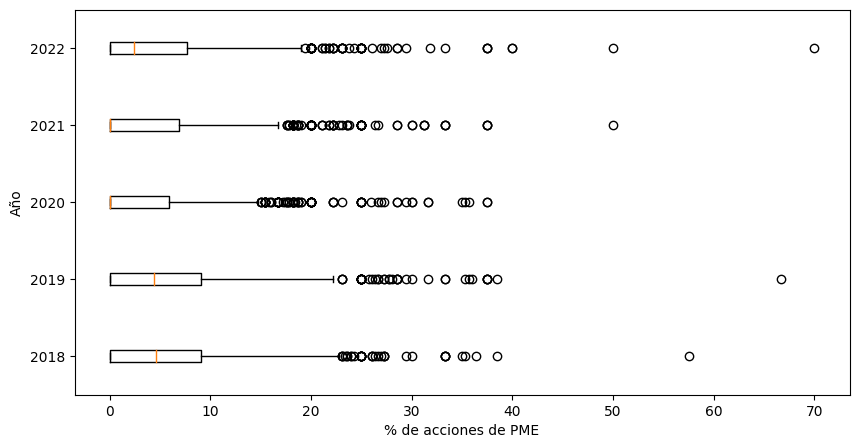

In [119]:
#  tres casos: todas las asignaturas, ciencias, leng + mat
cols_asignaturas = ['Uxxi_Tinno_Slect_lectura','Uxxi_Tinno_Slect_lenguaje_y_comunicacion','Uxxi_Tinno_Slect_literatura',
                    'Uxxi_Tinno_Sing_ingles','Uxxi_Tinno_Smat_matematica','Uxxi_Tinno_Snat_ciencias_naturales',
                    'Uxxi_Tinno_Snat_quimica','Uxxi_Tinno_Snat_fisica','Uxxi_Tinno_Snat_biologia',
                    'Uxxi_Tinno_Ssoc_ciencias_sociales','Uxxi_Tinno_Ssoc_historia','Uxxi_Tinno_Ssoc_geografia',
                    'Uxxi_Tinno_Sedfi_educacion_fisica','Uxxi_Tinno_Sart_arte','Uxxi_Tinno_Sart_musica',
                    'Uxxi_Tinno_Sori_orientacion','Uxxi_Tinno_Sori_consejo_de_curso']

cols_ciencias = ['Uxxi_Tinno_Snat_ciencias_naturales',
                    'Uxxi_Tinno_Snat_quimica','Uxxi_Tinno_Snat_fisica','Uxxi_Tinno_Snat_biologia']

cols_lect_mat = ['Uxxi_Tinno_Slect_lectura','Uxxi_Tinno_Slect_lenguaje_y_comunicacion','Uxxi_Tinno_Smat_matematica']

fig, ax = plt.subplots(figsize= (10,5))
for a in [2022,2021,2020,2019,2018]:
    data_a = data_EM[data_EM.agno == a]
    ax.boxplot(100*data_a[cols_lect_mat].sum(axis=1)/data_a.total_acciones, vert =False, positions=[a])
plt.ylabel('Año')
plt.xlabel('% de acciones de PME')
plt.savefig(r'Figuras\F11_distribucion_asignaturas_PME.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)

# Preguntas de interés

In [120]:
for x in df_planificacion_total_rbd.columns:
    print(x)

agno
rbd
region
deprov
comuna
dependencia
todo_texto_accion
total_acciones
rural_rbd
parvularia_ind
básica_niños_ind
media_hc_jóvenes_ind
media_tp_y_artística_jóvenes_ind
básica_adultos_ind
media_hc_adultos_ind
media_tp_y_artística_adultos_ind
básica_adultos
básica_niños
media_hc_adultos
media_hc_jóvenes
media_tp_y_artística_adultos
media_tp_y_artística_jóvenes
parvularia
n_docentes
horas_contrato
horas_direct
horas_tec_ped
horas_aula
ano_servicio_sistema
ano_servicio_ee
total_niveles
total_matricula
asistencia
prioritario_alu
idps_am
idps_cc
idps_hv
idps_pf
prom_idps
prom_lect
prom_mate
prom_mate_lect
fecha_duracion_meses
total_planes
plan_de_sexualidad_afectividad_y_género_ind
plan_de_desarollo_profesional_docente_ind
plan_de_gestión_de_la_convivencia_escolar_ind
plan_de_formación_ciudadana_ind
plan_integral_de_seguridad_escolar_ind
plan_de_apoyo_a_la_inclusión_ind
ninguno_ind
n_frases_descripcion_plan
n_palabras_descripcion_plan
n_palabras_unicas_descripcion_plan
n_caracteres_descri

## ¿Cuántos concepto por EE?

In [130]:
data_a[[x for x in df_planificacion_total_rbd.columns if 'TOPIC_' in x]].sum(axis=1)

0       1
1       0
2       3
3       3
4       4
       ..
8585    0
8586    2
8587    3
8588    5
8589    3
Length: 8590, dtype: int64

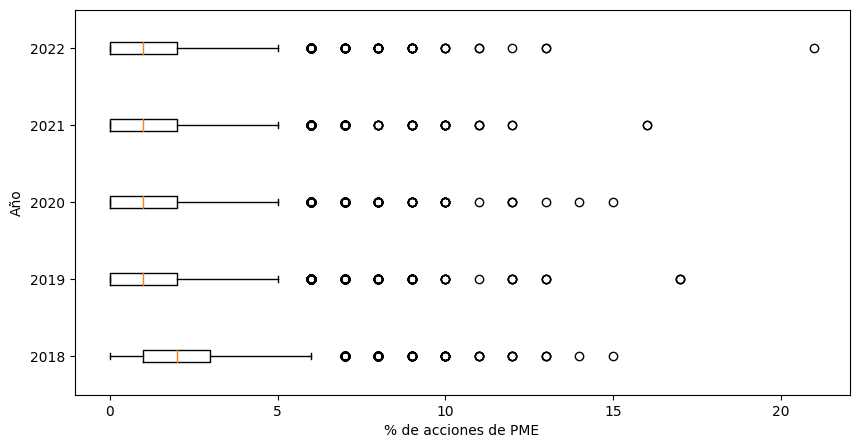

In [131]:
fig, ax = plt.subplots(figsize= (10,5))
for a in [2022,2021,2020,2019,2018]:
    data_a = df_planificacion_total_rbd[df_planificacion_total_rbd.agno == a]
    ax.boxplot(data_a[[x for x in df_planificacion_total_rbd.columns if 'TOPIC_' in x]].sum(axis=1), vert =False, positions=[a])
plt.ylabel('Año')
plt.xlabel('% de acciones de PME')
plt.savefig(r'Figuras\F12_distribucion_topic_total_PME.png',dpi=200,bbox_inches='tight', 
               transparent=True,
               pad_inches=0)

## ¿Qué tipo de establecimientos presentan mayor cantidad de actividades referidas a la mejora de los aprendizajes, por región y años del estudio?

In [121]:
# Quintilizar
df_planificacion_total_rbd['REACT_aprendizajes_quintil'] = pd.qcut(df_planificacion_total_rbd['REACT_aprendizajes'], 5, 
                                                                   labels = [1,2,3,4,5] )

cols_cont = ['prom_mate', 'prom_lect','prom_idps','total_matricula','asistencia','prioritario_alu', 
             'total_acciones', 'total_niveles', 'rural_rbd', 'ano_servicio_sistema']

cols_cont_dict = {'prom_mate':'SIMCE matemáticas', 'prom_lect':'SIMCE lectura','prom_idps': ' Promedio IDPS',
                  'total_matricula': 'Matrícula','asistencia':'Asistencia promedio',
                  'prioritario_alu': 'Prioritarios (%)', 'total_acciones': 'Acciones PME (N)',
                  'total_niveles': 'Niveles de enseñanza',
                  'rural_rbd': 'Establecimientos rurales (%)', 
                  'ano_servicio_sistema': 'Experiencia docentes (años promedio)'}

# Nacional
list_tot = []
for case in [1,2,3,4,5]:
    print(case)
    data = df_planificacion_total_rbd[df_planificacion_total_rbd['REACT_aprendizajes_quintil'] == case]
    list_case = list(data[cols_cont].mean().values)
    list_case += list((100*data['dependencia'].value_counts()/len(data)).values)
    list_tot += [list_case]

df = pd.DataFrame(list_tot).T
df.columns = ['Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']
df.index = [cols_cont_dict[x] for x in cols_cont] + ['Particular Subvencionado (%)', 'Municipal DAEM (%)',
                                                     'Corporación Municipal (%)', 'Servicio locales de Educacion (%)',
                                                     'Corporación Privada o de administración delegada (%)']

df = np.round(df,2)
dict_tablas['mas_acciones_pme_nacional'] = df
display(df)

1
2
3
4
5


,Quintil 1,Quintil 2,Quintil 3,Quintil 4,Quintil 5
SIMCE matemáticas,240.39,240.65,241.81,243.02,246.52
SIMCE lectura,240.05,239.77,240.36,240.53,243.06
Promedio IDPS,77.53,77.17,76.62,75.77,75.15
Matrícula,182.51,240.14,315.49,400.59,540.00
Asistencia promedio,92.47,91.96,91.32,90.81,90.66
Prioritarios (%),0.78,0.77,0.74,0.72,0.69
Acciones PME (N),10.09,12.93,16.76,21.21,31.92
Niveles de enseñanza,1.62,1.75,1.92,2.06,2.26
Establecimientos rurales (%),0.55,0.47,0.35,0.25,0.17
Experiencia docentes (años promedio),14.93,14.67,14.15,13.95,13.59


In [122]:
# Por región
lis_vals = []
for reg in df_planificacion_total_rbd.region.unique():
    print(reg)
    data_reg = df_planificacion_total_rbd[df_planificacion_total_rbd.region == reg]
    
    data_reg.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_reg['REACT_aprendizajes'], 5, 
                                                                   labels = [1,2,3,4,5] )
    
    
    list_tot = []
    for case in [1,2,3,4,5]:
        data = data_reg[data_reg['REACT_aprendizajes_quintil'] == case]
        list_case = list(data[cols_cont].mean().values)
        list_case += list((100*data['dependencia'].value_counts()/len(data)).values)
        list_tot += [list_case]

    df = pd.DataFrame(list_tot).T
    df.columns = ['Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']
    df.index = [cols_cont_dict[x] for x in cols_cont] + list(data_reg['dependencia'].value_counts().index)

    df = np.round(df,2)
    
    lis_vals += [list(df['Quintil 5'].values)]

df_tot = pd.DataFrame(lis_vals, columns = df.index)
df_tot.index = df_planificacion_total_rbd.region.unique()
dict_tablas['mas_acciones_pme_region'] = df_tot

df_tot

DE ARICA Y PARINACOTA  
DE TARAPACÁ            
DE ANTOFAGASTA         
DE ATACAMA             
DE COQUIMBO           
DE VALPARAÍSO          
DEL LIBERTADOR BERNARDO OHIGGINS   
DEL MAULE              


C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\1856238383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_reg['REACT_aprendizajes'], 5,
C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\1856238383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_reg['REACT_aprendizajes'], 5,
C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\1856238383.py:7: SettingWithCopy

DE ÑUBLE
DEL BIOBÍO            
DE LA ARAUCANÍA        
DE LOS RÍOS            
DE LOS LAGOS           
DE AYSÉN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO
DE MAGALLANES Y DE LA ANTÁRTICA CHILENA
METROPOLITANA DE SANTIAGO          


C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\1856238383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_reg['REACT_aprendizajes'], 5,
C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\1856238383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_reg['REACT_aprendizajes'], 5,
C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\1856238383.py:7: SettingWithCopy

,SIMCE matemáticas,SIMCE lectura,Promedio IDPS,Matrícula,Asistencia promedio,Prioritarios (%),Acciones PME (N),Niveles de enseñanza,Establecimientos rurales (%),Experiencia docentes (años promedio),Particular Subvencionado,Corporación Municipal,Municipal DAEM,Servicio locales de Educacion,Corporación Privada o de administración delegada
DE ARICA Y PARINACOTA,257.69,247.81,74.47,838.88,92.33,0.72,34.75,2.26,0.03,15.49,54.95,45.05,NaN,NaN,NaN
DE TARAPACÁ,236.91,237.29,73.98,671.60,89.26,0.70,29.83,2.62,0.20,12.80,46.77,40.32,12.90,NaN,NaN
DE ANTOFAGASTA,245.13,243.36,74.76,711.84,90.50,0.61,27.97,1.82,0.06,14.13,56.20,28.47,15.33,NaN,NaN
DE ATACAMA,237.82,238.89,74.72,598.97,88.60,0.74,28.37,2.21,0.08,13.92,77.39,22.61,NaN,NaN,NaN
DE COQUIMBO,244.80,245.22,76.58,511.37,91.49,0.69,28.64,2.28,0.23,14.48,52.33,30.60,9.09,7.98,NaN
DE VALPARAÍSO,243.27,240.10,74.19,458.65,90.89,0.68,33.44,2.33,0.08,13.54,56.08,31.90,10.30,1.57,0.14
DEL LIBERTADOR BERNARDO OHIGGINS,245.61,243.79,77.09,378.97,92.58,0.70,24.14,2.11,0.35,13.66,39.28,35.24,14.86,9.98,0.64
DEL MAULE,250.34,245.98,78.13,452.49,93.16,0.75,34.82,2.21,0.38,12.41,61.62,38.06,0.32,NaN,NaN
DE ÑUBLE,254.72,249.92,78.19,446.91,94.01,0.73,21.37,2.33,0.26,12.42,55.67,41.58,2.75,NaN,NaN
DEL BIOBÍO,248.45,243.90,76.32,512.43,91.70,0.71,31.09,2.17,0.15,13.04,50.55,43.10,5.98,0.37,NaN


In [123]:
# Por año
for a in range(2018,2023):
    print(a)
    data_a = df_planificacion_total_rbd[df_planificacion_total_rbd.agno == a]
    
    data_a.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_a['REACT_aprendizajes'], 5, 
                                                                   labels = [1,2,3,4,5] )
    
    
    list_tot = []
    for case in [1,2,3,4,5]:
        data = data_a[data_a['REACT_aprendizajes_quintil'] == case]
        list_case = list(data[cols_cont].mean().values)
        list_case += list((100*data['dependencia'].value_counts()/len(data)).values)
        list_tot += [list_case]

    df = pd.DataFrame(list_tot).T
    df.columns = ['Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']
    df.index = [cols_cont_dict[x] for x in cols_cont] + ['Particular Subvencionado (%)', 'Municipal DAEM (%)',
                                                     'Corporación Municipal (%)', 'Servicio locales de Educacion (%)',
                                                     'Corporación Privada o de administración delegada (%)']


    df = np.round(df,2)
    
    if a == 2018:
        df_tot = df[['Quintil 5']]
    else:
        df_tot = pd.concat([df_tot, df[['Quintil 5']]], axis=1)
    
df_tot.columns = range(2018,2023)

dict_tablas['mas_acciones_pme_agno'] = df_tot

display(df_tot)

C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\3202815819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_a.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_a['REACT_aprendizajes'], 5,
C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\3202815819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_a.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_a['REACT_aprendizajes'], 5,


2018
2019
2020
2021


C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\3202815819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_a.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_a['REACT_aprendizajes'], 5,
C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\3202815819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_a.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_a['REACT_aprendizajes'], 5,


2022


C:\Users\JoaquinFarina\AppData\Local\Temp\ipykernel_14468\3202815819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_a.loc[:,'REACT_aprendizajes_quintil'] = pd.qcut(data_a['REACT_aprendizajes'], 5,


,2018,2019,2020,2021,2022
SIMCE matemáticas,244.44,252.58,NaN,NaN,NaN
SIMCE lectura,248.92,234.69,NaN,NaN,NaN
Promedio IDPS,74.79,75.10,NaN,NaN,NaN
Matrícula,517.37,541.67,559.04,592.21,591.01
Asistencia promedio,91.95,90.99,92.67,87.07,87.44
Prioritarios (%),0.70,0.69,0.66,0.66,0.70
Acciones PME (N),37.79,33.54,29.52,29.21,29.07
Niveles de enseñanza,2.26,2.28,2.28,2.34,2.32
Establecimientos rurales (%),0.19,0.16,0.15,0.12,0.11
Experiencia docentes (años promedio),13.41,13.35,13.73,13.97,13.81


In [124]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r'Tablas\tablas_establecimientos_mas_acciones_aprendizaje.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
for var in dict_tablas.keys():
    print(var)
    dict_tablas[var].to_excel(writer, sheet_name=var[:31])
# Close the Pandas Excel writer and output the Excel file.
writer.close()

casos_interesantes
mas_acciones_pme_nacional
mas_acciones_pme_region
mas_acciones_pme_agno


## ¿Cuál es la relación entre el estado de los establecimientos definidos por la Agencia de Calidad y los PME enfocados en la mejora de los aprendizajes?, ¿y su relación a la cantidad de matrícula en cada uno de los años del estudio?


RESPONDIDO EN PREGUNTA ANTERIOR